based on the paper __2003 Schmidhuber - Exploring the Predictable__

# __Create the Agent!__

In [4]:
import numpy as np
from __future__ import division


class LRRL:                            # LEFT and RIGHT Reinforcement Learner
    m=576; n=24; M=100000; BS=9
    room_size = 100.0                               # 1000 en l'originale mais ça prends beaucoup de temps
    
    def __init__(self, agent_type = 'creative'):
        
        # definitions that involve BOTH modulos
        self.IP = 0                               # from 0 to m-1
        self.S = np.zeros((LRRL.m), dtype=np.int) # from -M to M
        self.Q = np.zeros((LRRL.m,LRRL.n))        # useless intialization, it will be redefined after
        self.time = 0
        self.direction = 0
        self.position = [50.0, 50.0]
        self.gvector, self.BSvector, self.noBS = self.define_g_and_BSvector_and_noBS()
        self.world = []
        self.room = 1
        self.reward_sequence = [[self.time], ['None']]  # time, tag of external reward found 
        self.path = [[self.room, self.time, self.position]]
        self.list_of_actions = []
        if agent_type == 'creative':
            self.agent_type = 0
        elif agent_type == 'non-creative':
            self.agent_type = 1
        elif agent_type == 'random-walker':
            self.agent_type = 2    
        elif agent_type == 'random-motionless':
            self.agent_type = 3
        
            
        # LEFT things
        self.LEFT = np.ones((LRRL.m,LRRL.n))/LRRL.n
        self.LEFT_reward = 0
        self.LEFT_reward_track = [[self.time], [self.LEFT_reward], ['None']] # time, reward accumulated, 'internal' or 'external'
        self.Stack_LEFT = []
        self.Block_SSA_LEFT = True
        self.LEFT_columns_modified = [0]*LRRL.m
        self.size_LEFT_Stack = [[self.time, 0]]
        
        # RIGHT same things
        self.RIGHT = np.ones((LRRL.m,LRRL.n))/LRRL.n
        self.RIGHT_reward = 0
        self.RIGHT_reward_track = [[self.time], [self.RIGHT_reward], ['None']] # time, reward accumulated, 'internal' or 'external'
        self.Stack_RIGHT = []
        self.Block_SSA_RIGHT = True
        self.RIGHT_columns_modified = [0]*LRRL.m
        self.size_RIGHT_Stack = [[self.time, 0]]
        
    def define_g_and_BSvector_and_noBS(self):
        # minor modification, that will link in the Q function some LEFT instructions
        # with the correspoding RIGHT instruction

        g_vector = range(LRRL.n)
        g_vector_modified = g_vector[:]

        LEFT_instrictions = [10, 13, 15, 16, 17]
        RIGHT_instructions = [11, 14, 18, 19, 20]

        for i,j in zip(LEFT_instrictions,RIGHT_instructions):
            g_vector_modified[j] = g_vector[i]
            g_vector_modified[i] = g_vector[j]
        
        BS_vector = [i*LRRL.BS for i in range(LRRL.m) if i*LRRL.BS<LRRL.m]
        all_possible_i = range(LRRL.m)
        all_possible_i_without_BSs = [x for x in all_possible_i if x not in BS_vector]
        
        return g_vector_modified, BS_vector, all_possible_i_without_BSs
    
    def select_an_action(self):  
        if self.agent_type == 0:
            a = np.random.choice(LRRL.n, 1, p=self.Q[self.IP,:])[0]
        elif self.agent_type == 1:
            a = np.random.choice(LRRL.n, 1, p=self.Q[self.IP,:])[0]
            if a == 12: 
                # since this is the non-creative agent, this if is
                # to avoid the creative action
                a = np.random.choice(LRRL.n, 1, p=self.Q[self.IP,:])[0]
        elif self.agent_type == 2:
            a = 8 + np.random.choice(2, 1, p=[1/2]*2)[0]
        elif self.agent_type == 3:
            a = 10 + np.random.choice(14, 1, p=[1/14]*14)[0]
        return a
        
    def update_Q(self):     
        
        for i in self.noBS:
            for j in range(LRRL.n):
                self.Q[i,j] = self.collective_decision_f(self.LEFT[i,j],self.RIGHT[i,j])
            normalizer = sum(self.Q[i,:])
            self.Q[i,:] = self.Q[i,:]/normalizer
            
        for i in self.BSvector:
            for j in range(LRRL.n):
                self.Q[i,j] = self.collective_decision_f(self.RIGHT[i,j],self.LEFT[i,self.gvector[j]])
            normalizer = sum(self.Q[i,:])
            self.Q[i,:] = self.Q[i,:]/normalizer
            
    
    def collective_decision_f(self,a,b):
        return a*b
        
    def two_values_to_one(self,xyz1,xyz2):
        return (xyz1*LRRL.n+xyz2)%LRRL.m
    
    def change_IP(self):
        w1 = np.random.choice(LRRL.n, 1, p=self.Q[self.IP+7,:])[0]
        w2 = np.random.choice(LRRL.n, 1, p=self.Q[self.IP+8,:])[0]
        w = self.two_values_to_one(w1,w2)
        
        self.IP = w-w%LRRL.BS
        
    def choose_parameters_for_a(self):
        x = np.zeros(6, dtype=np.int)        
        for i in range(6):
            x[i] = np.random.choice(LRRL.n, 1, p=self.Q[self.IP+i+1,:])[0]
        return x
    
    
    def act_action(self,a):
        [x1,x2,y1,y2,z1,z2] = self.choose_parameters_for_a()
        
        # A.3.1 Change Internal State Only
        if   a == 0:
            self.Jmpl(x1,x2,y1,y2,z1,z2)      # change IP
        elif a == 1:
            self.Jmpeq(x1,x2,y1,y2,z1,z2)     # change IP
        elif a == 2:
            self.Add(x1,x2,y1,y2,z1,z2)
        elif a == 3:
            self.Sub(x1,x2,y1,y2,z1,z2)
        elif a == 4:
            self.Mul(x1,x2,y1,y2,z1,z2)
        elif a == 5:
            self.Div(x1,x2,y1,y2,z1,z2)
        elif a == 6:
            self.Mov(x1,x2,y1,y2)
        elif a == 7:
            self.Init(x1,x2,y1,y2)
        
        # A.3.2 Change Environment
        elif a == 8:
            self.MoveAgent()
        elif a == 9:
            self.SetDirection(x1)
        
        # A.3.3 Introspective Instructions
        elif a == 10:
            self.GetLEFT(x1,x2,y1)
        elif a == 11:
            self.GetRIGHT(x1,x2,y1)
            
        # A.3.4 Bet Instruction
        elif a == 12:
            self.Betttt(x1,x2,y1,y2)
            
        # A.3.5 SSA-enabling Instructions
        elif a == 13:
            self.EnableSSALEFT(x1)
        elif a == 14:
            self.EnableSSARIGHT(x1)
            
        # A.3.6 Primitive Learning Algorithms
        elif a == 15:
            self.IncProbLEFT(x1,x2,y1)
        elif a == 16:
            self.DecProbLEFT(x1,x2,y1)
        elif a == 17:
            self.MoveDistLEFT(x1,x2,y1,y2)
        elif a == 18:
            self.IncProbRIGHT(x1,x2,y1)
        elif a == 19:
            self.DecProbRIGHT(x1,x2,y1)
        elif a == 20:
            self.MoveDistRIGHT(x1,x2,y1,y2)
        elif a == 21:
            self.IncProbBOTH(x1,x2,y1)
        elif a == 22:
            self.DecProbBOTH(x1,x2,y1)
        elif a == 23:
            self.SSAandCopy(x1)
                
    # A.3 Instructions _____________________________________________________
    # A.3.1 Change Internal State Only _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
        
    def Jmpl(self,x1,x2,y1,y2,z1,z2):
        x = self.two_values_to_one(x1,x2)
        y = self.two_values_to_one(y1,y2)
        z = self.two_values_to_one(z1,z2)
        
        if self.S[x]<self.S[y]:
            self.IP = z-z%LRRL.BS
            
    def Jmpeq(self,x1,x2,y1,y2,z1,z2):
        x = self.two_values_to_one(x1,x2)
        y = self.two_values_to_one(y1,y2)
        z = self.two_values_to_one(z1,z2)
        
        if self.S[x]==self.S[y]:
            self.IP = z-z%LRRL.BS 

    def Add(self,x1,x2,y1,y2,z1,z2):
        x = self.two_values_to_one(x1,x2)
        y = self.two_values_to_one(y1,y2)
        z = self.two_values_to_one(z1,z2)
        
        self.S[z] = (self.S[x]+self.S[y])%LRRL.M
            
    def Sub(self,x1,x2,y1,y2,z1,z2):
        x = self.two_values_to_one(x1,x2)
        y = self.two_values_to_one(y1,y2)
        z = self.two_values_to_one(z1,z2)
        
        self.S[z] = (self.S[x]-self.S[y])%LRRL.M

    def Mul(self,x1,x2,y1,y2,z1,z2):
        x = self.two_values_to_one(x1,x2)
        y = self.two_values_to_one(y1,y2)
        z = self.two_values_to_one(z1,z2)
        
        self.S[z] = (self.S[x]*self.S[y])%LRRL.M
        
    def Div(self,x1,x2,y1,y2,z1,z2):
        x = self.two_values_to_one(x1,x2)
        y = self.two_values_to_one(y1,y2)
        z = self.two_values_to_one(z1,z2)
        
        if self.S[y] != 0:
            self.S[z] = (self.S[x]//self.S[y])%LRRL.M
            
    def Mov(self,x1,x2,y1,y2):
        x = self.two_values_to_one(x1,x2)
        y = self.two_values_to_one(y1,y2)
        
        self.S[y] = self.S[x]

    def Init(self,x1,x2,y1,y2):
        x = self.two_values_to_one(x1,x2)
        y = self.two_values_to_one(y1,y2)
        
        self.S[y] = x
        
    # A.3.2 Change Environment _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
    
    def MoveAgent(self):
        new_position = np.asarray(self.position) + np.asarray([12*np.cos(self.direction), 
                          12*np.sin(self.direction)])
        
        self.position = self.check_if_pushed_against_a_wall(new_position)
        self.path.append([self.room, self.time, self.position])
        self.change_inputs_after_movement()        
        
    def SetDirection(self,x1):
        self.direction = x1/LRRL.n*2*np.pi
        
        self.change_inputs_after_movement()
        
    def check_if_pushed_against_a_wall(self,new_position):
        # since the room is a square of corners (0,0), (1000,0), (1000,1000), (0,1000)
        # we go back some steps in case we went too far
        if ( new_position[0]<0.0 or new_position[0]> LRRL.room_size 
            or new_position[1]<0.0 or new_position[1]> LRRL.room_size ):
            old_position = new_position
            for i in range(1,13):
                old_position -= np.asarray([1*np.cos(self.direction), 
                                 1*np.sin(self.direction)])

                if ( old_position[0]>0.0 and old_position[0]< LRRL.room_size 
                    and old_position[1]>0.0 and old_position[1]< LRRL.room_size ): 
                    new_position = old_position
                    break
                    
        return new_position
            
    def change_inputs_after_movement(self):
        
        self.S[0] = np.round(self.position[0])%LRRL.room_size
        self.S[1] = np.round(self.position[1])%LRRL.room_size
        self.S[2] = np.round(self.direction/(2*np.pi)*100)
        
        
        # write properly so the agent can detect obstacles within 24u,
        # for now the only obstacles are going to be the 4 walls.
        # I define it in a slightly different manner wrt the one 
        # implemented by Jurgen. Mine simpler.
        
        if self.position[0] < 24.0: self.S[3] = 24
        else:
            self.S[3] = 0
            
        if self.position[0] > LRRL.room_size-24.0: self.S[4] = 24
        else:
            self.S[4] = 0
            
        if self.position[1] < 24.0: self.S[5] = 24
        else:
            self.S[5] = 0
            
        if self.position[1] > LRRL.room_size-24.0: self.S[6] = 24
        else:
            self.S[6] = 0    
        
                
        
    # A.3.3 Introspective Instructions _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

    def GetLEFT(self,x1,x2,y1):
        x = self.two_values_to_one(x1,x2)        
        self.S[x] = np.round(LRRL.M*self.LEFT[x,y1])        
        
    def GetRIGHT(self,x1,x2,y1):
        x = self.two_values_to_one(x1,x2)        
        self.S[x] = np.round(LRRL.M*self.RIGHT[x,y1])
            
            
    # A.3.4 Bet Instructions _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
    
    def Betttt(self,x1,x2,y1,y2):  
        # in the paper (x1,x2,y1,y2,c,d), which doesn't make much sense if
        # c and d are going to be determined inside here.
        
        prob_c = self.LEFT[self.IP+5,:]
        prob_c /=np.sum(prob_c)
        
        c = np.random.choice(LRRL.n, 1, p=prob_c)[0]
        
        if c>LRRL.n/2: c=1
        else: c=-1
    
        prob_d = self.RIGHT[self.IP+5,:]
        prob_d /=np.sum(prob_d)
        
        d = np.random.choice(LRRL.n, 1, p=prob_d)[0]
    
        if d>LRRL.n/2: d=1
        else: d=-1
        
        # if both modules bet the same, it's not fun anymore, nobody wins,
        # and we get out of the function
        
        if c==d: return
        
        # if each module bets something different, let's see who wins
        
        x = self.two_values_to_one(x1,x2)
        y = self.two_values_to_one(y1,y2)
        
        # it is incentivating betting high numbers, big c's, which I don't
        # think makes much sense

        if self.S[x]==self.S[y]:
            self.LEFT_reward += c
            self.RIGHT_reward += -c
        else:
            self.LEFT_reward += -c
            self.RIGHT_reward += c
        
        # we keep track of the history of rewards
        self.LEFT_reward_track[0].append(self.time)
        self.LEFT_reward_track[1].append(self.LEFT_reward)
        self.LEFT_reward_track[2].append('internal')
        self.RIGHT_reward_track[0].append(self.time)
        self.RIGHT_reward_track[1].append(self.RIGHT_reward)
        self.RIGHT_reward_track[2].append('internal')

        # the reward becomes visible
        self.S[7] = c
        
        
    # A.3.5 SSA-enabling Instructions _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
    
    def EnableSSALEFT(self,x1):
        if x1 < 10:
            self.Block_SSA_LEFT = False                
                
    def EnableSSARIGHT(self,x1):
        if x1 < 10:
            self.Block_SSA_RIGHT = False
    
    
    # A.3.6 Primitive Learning Instructions (LI) _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
    
    def check_if_push_needed(self, x, Stack, LEFT_or_RIGHT, accumulated_module_reward, stack_length):
        if len(Stack)==0:
            new_block = [self.time, accumulated_module_reward]
            Stack.append(new_block)
            stack_length.append([self.time, len(Stack)])
        
        Last_Block = Stack[-1]
        
        # save the column that is going to be modified if it hasn't been
        # modified before since last checkpoint
        
        # number columns_already saved
        n_cas = len(Last_Block)
           
        for i in range(2,n_cas):            
            if Last_Block[i][0]==x:
                return
            
        Stack[-1].append([x, LEFT_or_RIGHT[x,:]])
                        
        
    def IncProbLEFT(self,x1,x2,y1):
    
        # 1.
        self.SSA_LEFT()
    
        # 2.
        x = self.two_values_to_one(x1,x2)
        self.check_if_push_needed(x, self.Stack_LEFT, self.LEFT, self.LEFT_reward, self.size_LEFT_Stack)        
        
        # 3.
        temporary_LEFT = np.ones(LRRL.n)
        lambbda = .3
        for k in range(LRRL.n):
            if k != y1:
                temporary_LEFT[k] = lambbda*self.LEFT[x,k]
            else:
                temporary_LEFT[k] = 1-lambbda*(1-self.LEFT[x,k])
        
        # IncProbLEFT has an effect only if no element in self.LEFT has gone
        # below MinProb
        
        MinProb = .4
        
        # number of elements that went below MinProb
        n_below = sum([i < MinProb for i in temporary_LEFT]) 
        if n_below == 0:
            self.LEFT[x,:] = temporary_LEFT
            self.LEFT_columns_modified[x]=1
            
        
    def DecProbLEFT(self,x1,x2,y1):
        
        # 1.
        self.SSA_LEFT()
    
        # 2.
        x = self.two_values_to_one(x1,x2)
        self.check_if_push_needed(x, self.Stack_LEFT, self.LEFT, self.LEFT_reward, self.size_LEFT_Stack)        
        
        # 3.
        temporary_LEFT = np.ones(LRRL.n)
        lambbda = .3
        for k in range(LRRL.n):
            if k != y1:
                temporary_LEFT[k] = ( (1-lambbda*self.LEFT[x,k])/(1-self.LEFT[x,k])
                                     *self.LEFT[x,k] )
            else:
                temporary_LEFT[k] = lambbda*self.LEFT[x,k]
        
        # IncProbLEFT has an effect only if no element in self.LEFT has gone
        # below MinProb
        
        MinProb = .4
        
        # number of elements that went below MinProb
        n_below = sum([i < MinProb for i in temporary_LEFT]) 
        if n_below == 0:
            self.LEFT[x,:] = temporary_LEFT
            self.LEFT_columns_modified[x]=1
                
    
    def MoveDistLEFT(self,x1,x2,y1,y2):
        # 1.
        self.SSA_LEFT()
    
        # 2.
        x = self.two_values_to_one(x1,x2)
        y = self.two_values_to_one(y1,y2)
        self.check_if_push_needed(x, self.Stack_LEFT, self.LEFT, self.LEFT_reward, self.size_LEFT_Stack) 
        
        # 3.
        self.LEFT[x,:] = self.LEFT[y,:]
        self.LEFT_columns_modified[x]=1
        
        
    def IncProbRIGHT(self,x1,x2,y1):
    
        # 1.
        self.SSA_RIGHT()
    
        # 2.
        x = self.two_values_to_one(x1,x2)
        self.check_if_push_needed(x, self.Stack_RIGHT, self.RIGHT, self.RIGHT_reward, self.size_RIGHT_Stack)        
        
        # 3.
        temporary_RIGHT = np.ones(LRRL.n)
        lambbda = .3
        for k in range(LRRL.n):
            if k != y1:
                temporary_RIGHT[k] = lambbda*self.RIGHT[x,k]
            else:
                temporary_RIGHT[k] = 1-lambbda*(1-self.RIGHT[x,k])
        
        # IncProbLEFT has an effect only if no element in self.LEFT has gone
        # below MinProb
        
        MinProb = .4
        
        # number of elements that went below MinProb
        n_below = sum([i < MinProb for i in temporary_RIGHT]) 
        if n_below == 0:
            self.RIGHT[x,:] = temporary_RIGHT
            self.RIGHT_columns_modified[x]=1
            
        
    def DecProbRIGHT(self,x1,x2,y1):
        
        # 1.
        self.SSA_RIGHT()
    
        # 2.
        x = self.two_values_to_one(x1,x2)
        self.check_if_push_needed(x, self.Stack_RIGHT, self.RIGHT, self.RIGHT_reward, self.size_RIGHT_Stack)        
        
        # 3.
        temporary_RIGHT = np.ones(LRRL.n)
        lambbda = .3
        for k in range(LRRL.n):
            if k != y1:
                temporary_RIGHT[k] = self.RIGHT[x,k] = (1-lambbda*self.RIGHT[x,k])
                /(1-self.RIGHT[x,k])*self.RIGHT[x,k]
            else:
                temporary_RIGHT[k] = lambbda*self.RIGHT[x,k]
        
        # IncProbLEFT has an effect only if no element in self.LEFT has gone
        # below MinProb
        
        MinProb = .4
        
        # number of elements that went below MinProb
        n_below = sum([i < MinProb for i in temporary_RIGHT]) 
        if n_below == 0:
            self.RIGHT[x,:] = temporary_RIGHT
            self.RIGHT_columns_modified[x]=1
                
    
    def MoveDistRIGHT(self,x1,x2,y1,y2):
        # 1.
        self.SSA_RIGHT()
    
        # 2.
        x = self.two_values_to_one(x1,x2)
        y = self.two_values_to_one(y1,y2)
        self.check_if_push_needed(x, self.Stack_RIGHT, self.RIGHT, self.RIGHT_reward, self.size_RIGHT_Stack) 
        
        # 3.
        self.RIGHT[x,:] = self.RIGHT[y,:]
        self.RIGHT_columns_modified[x]=1
        
        
    def IncProbBOTH(self,x1,x2,y1):
        if np.random.rand()<.5:
            self.IncProbLEFT(x1,x2,y1)
            self.IncProbRIGHT(x1,x2,y1)
        else:
            self.IncProbRIGHT(x1,x2,y1)
            self.IncProbLEFT(x1,x2,y1)

            
    def DecProbBOTH(self,x1,x2,y1):
        if np.random.rand()<.5:
            self.DecProbLEFT(x1,x2,y1)
            self.DecProbRIGHT(x1,x2,y1)
        else:
            self.DecProbRIGHT(x1,x2,y1)
            self.DecProbLEFT(x1,x2,y1)
        
        
    def SSAandCopy(self,x1):
        # TODO: check it works properly
        
        #print 'x1 = ', x1
        if x1 >= 5: return
        
        self.Block_SSA_LEFT = False
        self.Block_SSA_RIGHT = False
            
        if np.random.rand()<.5:
            self.SSA_LEFT()
            self.SSA_RIGHT()
        else:
            self.SSA_RIGHT()
            self.SSA_LEFT()
        
        # the following condition is to avoid division by zero in self.SSC()
        #print 'we get before the return'
        if self.time == self.Stack_LEFT[-1][0]: return
        if self.time == self.Stack_RIGHT[-1][0]: return
        #print 'and we get after too'
        #print
        # see which of the two modules is performing better and
        # improve the one lagging behind by substituting it by
        # a copy of the winner        
        SSC_LEFT = self.SSC(self.Stack_LEFT,self.LEFT_reward)
        SSC_RIGHT= self.SSC(self.Stack_RIGHT,self.RIGHT_reward)
        
        # Find the columns in the superior module that
        # differ from the other.
        for i,j,column in zip(self.LEFT_columns_modified, self.RIGHT_columns_modified, range(LRRL.m)):
            if i == 1 or j == 1:
                print 'successfull copy at time ', self.time
                if SSC_LEFT > SSC_RIGHT:
                    # Save (push) the losers columns
                    self.check_if_push_needed(column, self.Stack_RIGHT, self.RIGHT, self.RIGHT_reward, self.size_RIGHT_Stack)           

                    # Copy the winner's columns to the loser's
                    self.RIGHT[column,:] = self.LEFT[column,:]
                else:                    
                    # Save (push) the losers columns
                    self.check_if_push_needed(column, self.Stack_LEFT, self.LEFT, self.LEFT_reward, self.size_LEFT_Stack)           

                    # Copy the winner's columns to the loser's
                    self.LEFT[column,:] = self.RIGHT[column,:]      
                    
        # reset the counter of differences between the two modulos           
        self.LEFT_columns_modified  = [0]*LRRL.m
        self.RIGHT_columns_modified = [0]*LRRL.m

                    
    def SSC(self,Stack, reward):
        return (reward-Stack[-1][1])/(self.time-Stack[-1][0])
    
    
    # A.2 SSA Calls ________________________________________________________
    
    def SSA_LEFT(self):
        # 1.
        if self.Block_SSA_LEFT == True: return
        
        # 2.
        else:
            self.Block_SSA_LEFT = True
            
            # the LI actions will add the columns that will be modified
            # in LEFT to the new_block that follows

            new_block = [self.time, self.LEFT_reward]    
            
            if self.Stack_LEFT:

                SSC_previous = 0
                
                # check check the past checkpoints, in case they still
                # show an improvement in SSC, to remove in case they don't
                
                i=0
                for x in reversed(self.Stack_LEFT):
                    i+=1
                    SSC = (new_block[1]-x[1])/(new_block[0]-x[0])
                    # print 'at time ', x[0], ' SSC is ', SSC

                    if SSC<SSC_previous:
                        # if we enter this if, it means that from this block 
                        # on in the past, the SSC criterion will be satisfied
                        # so we don't need to keep going back in the past
                        # checkpoints
                        break

                    SSC_previous = SSC
                    
                # after checking the past, we remove memories from the past 
                # that don't lead anymore to an improvement in SSC
                
                for j in range(1,i):
                    del self.Stack_LEFT[-1]
                    

            self.Stack_LEFT.append(new_block)
            self.size_LEFT_Stack.append([self.time, len(self.Stack_LEFT)])
    
    def SSA_RIGHT(self):
        # 1.
        if self.Block_SSA_RIGHT == True: return
        
        # 2.
        else:
            self.Block_SSA_RIGHT = True
            
            # the LI actions will add the columns that will be modified
            # in RIGHT to the new_block that follows

            new_block = [self.time, self.RIGHT_reward]    
            
            if self.Stack_RIGHT:

                SSC_previous = 0
                
                # check check the past checkpoints, in case they still
                # show an improvement in SSC, to remove in case they don't
                
                i=0
                for x in reversed(self.Stack_RIGHT):
                    i+=1
                    SSC = (new_block[1]-x[1])/(new_block[0]-x[0])
                    #print 'at time ', x[0], ' SSC is ', SSC

                    if SSC<SSC_previous:
                        # if we enter this if, it means that from this block 
                        # on in the past, the SSC criterion will be satisfied
                        # so we don't need to keep going back in the past
                        # checkpoints
                        break

                    SSC_previous = SSC
                    
                # after checking the past, we remove memories from the past 
                # that don't lead anymore to an improvement in SSC
                
                for j in range(1,i):
                    del self.Stack_RIGHT[-1]

            self.Stack_RIGHT.append(new_block)
            self.size_RIGHT_Stack.append([self.time, len(self.Stack_RIGHT)])
            
            
            
    # Interactions with the world __________________________________________
    def check_if_reward(self):
        reward = 0
        any_reward_found = 0
        # check if the agent is on top of a reward botton
        for y in self.world[self.room]['Rewards']:
            reward_found = np.linalg.norm(np.asarray(y[0])
                                          -np.asarray(self.position))<y[1]
            any_reward_found += reward_found
            
            # second condition in the if is to make sure that the agent
            # doesn't get infinite reward just by staying still in the place
            # where he found a reward
            if reward_found and self.reward_sequence[1][-1] != y[3]:
                reward = y[2]
                self.reward_sequence[0].append(self.time)
                self.reward_sequence[1].append(y[3])
      
        if any_reward_found == 0 and self.reward_sequence[1][-1] != 0:
            self.reward_sequence[0].append(self.time)
            self.reward_sequence[1].append(0)
                
        # my special type of reward, the bonus the agent gets buy following
        # a specific sequence of rewards. I want the learner to learn these
        # sequences, to find them
        for y in self.world[self.room]['Sequences']:
            last_visited = (self.reward_sequence[1][-len(y[0]):-1] 
                            + [self.reward_sequence[1][-1]])           # python doesn't help here            
            sequence_coincidence = [i == j for i,j in zip(last_visited,y[0])]
            
            if all(sequence_coincidence) and len(y[0]) == len(last_visited): 
                reward += y[1]
                self.reward_sequence[0].append(self.time)
                self.reward_sequence[1].append(self.reward_sequence[1][-1])        
        
        if reward != 0:
            self.S[8] = reward
            
            self.LEFT_reward += reward
            self.RIGHT_reward += reward
            self.LEFT_reward_track[0].append(self.time)
            self.LEFT_reward_track[1].append(self.LEFT_reward)
            self.LEFT_reward_track[2].append('external')
            self.RIGHT_reward_track[0].append(self.time)
            self.RIGHT_reward_track[1].append(self.RIGHT_reward)
            self.RIGHT_reward_track[2].append('external')
            
            
        
    # A.1 Basic Cycle of Operations ________________________________________
    def learner_life(self,T,world):
        self.world = world
        
        for self.time in range(T):
            # 1.
            self.update_Q()
            
            IP_before_action = self.IP
            S_before_action = self.S[0:9]
            
            # 2.
            a = self.select_an_action()
            #a = 8
            self.list_of_actions.append(a)
            
            # 3.
            self.act_action(a)
            
            # Reward will be given only if the agent stops in a circle, not
            # if it passes on it while going somewhere else. Easier to code
            # this way.
            # A special reward will be given if it finds a specific sequence
            # of rewards locations.
            self.check_if_reward()
            
            # check_if_new_room() and charge all the parameters of the room
            
            # 4. Shift the content of the state if something has changed
            # in its first 10 positions
            if not all([x == y for x,y in zip(S_before_action,self.S[0:9])]):
                self.S[18:90] = self.S[9:81]
                self.S[9:18] = S_before_action
                # TODO: check it works properly
                
            
            # 5. Change IP if action didn't do it already
            if IP_before_action == self.IP:
                self.change_IP()

# __Create the World for the Agent!__

In [5]:

#____________________________________________ Room 1

# rewards will have (1) center, (2) radius, (3) price, 
# (4) number of reward
Reward_1_room_1 = [[10.0,50.0], 10.0, 10, 1]
Reward_2_room_1 = [[90.0,50.0], 20.0,  5, 2]
Reward_3_room_1 = [[80.0, 8.0], 20.0,  2, 3]
Rewards_room_1 = [Reward_1_room_1, Reward_2_room_1, Reward_3_room_1]

# since ideally I want the agent to learn patterns,
# one learnable patter she could learn would be that if
# she steps up a given sequence of rewards spots defined
# before, she could gain a bonus.
# sequences will have (1) the sequence, (2) the added reward, 
# (3) the times it takes to use up their power
# (4) the number that tags the sequence
Sequence_1_room_1 = [[1, 0, 1, 0, 2, 0, 3], 50, 10, 1]
Sequence_2_room_1 = [[2, 0, 1],              20, 10, 2]
Sequence_3_room_1 = [[2, 0, 2],              20, 10, 2]
Sequences_room_1 = [Sequence_1_room_1, Sequence_2_room_1, Sequence_3_room_1]

# gate openers will have (1) center, (2) radius, (3) the next room, 
# (4) where in the new room you appear, (5) center of the door and 
# (6) its radius
GateOpener_1_room_1 = [[600.0, 100.0], 50.0, 2, [700.0, 700.0], [1000.0, 1000.0], 200.0]
GateOpener_2_room_1 = [[900.0, 500.0], 60.0, 3, [20.0,  100.0], [ 500.0, 1000.0],  100.0]
GateOpeners_room_1 = [GateOpener_1_room_1, GateOpener_2_room_1]

#____________________________________________ Room 2

# rewards will have (1) center, (2) radius, (3) price, 
# (4) number of reward
Reward_1_room_2 = [[ 500.0,800.0], 100.0, 1000, 1]
Rewards_room_2 = [Reward_1_room_2]

# since ideally I want the agent to learn patterns,
# one learnable patter she could learn would be that if
# she steps up a given sequence of rewards spots defined
# before, she could gain a bonus.
# sequences will have (1) the sequence, (2) the added reward, 
# (3) the times it takes to use up their power
# (4) the number that tags the sequence
Sequences_room_2 = []

# gate openers will have (1) center, (2) radius, (3) the next room, 
# (4) where in the new room you appear, (5) center of the door and 
# (6) its radius
GateOpener_1_room_2 = [[600.0, 100.0], 50.0, 1, [700.0, 700.0], [0.0, 1000.0], 300.0]
GateOpeners_room_2 = [GateOpener_1_room_2]

#____________________________________________ Room 3

# rewards will have (1) center, (2) radius, (3) price, 
# (4) number of reward
Rewards_room_3 = []

# since ideally I want the agent to learn patterns,
# one learnable patter she could learn would be that if
# she steps up a given sequence of rewards spots defined
# before, she could gain a bonus.
# sequences will have (1) the sequence, (2) the added reward, 
# (3) the times it takes to use up their power
# (4) the number that tags the sequence
Sequences_room_3 = []

# gate openers will have (1) center, (2) radius, (3) the next room, 
# (4) where in the new room you appear, (5) center of the door and 
# (6) its radius
GateOpener_1_room_3 = [[500.0, 1000.0], 200.0, 2, [700.0, 700.0], [500.0, 0.0], 300.0]
GateOpeners_room_3 = [GateOpener_1_room_3]

#________________________________________________________________________this is the world

room_1 = {'Rewards': Rewards_room_1, 'Sequences': Sequences_room_1, 'Gate Openers': GateOpeners_room_1}
room_2 = {'Rewards': Rewards_room_2, 'Sequences': Sequences_room_2, 'Gate Openers': GateOpeners_room_2}
room_3 = {'Rewards': Rewards_room_3, 'Sequences': Sequences_room_3, 'Gate Openers': GateOpeners_room_3}

world = {1: room_1, 2: room_2, 3: room_3}
easy_world = {1: {'Rewards': Rewards_room_1, 'Sequences': Sequences_room_1, 'Gate Openers': []}}


# __Plot the World that was just created!__

(<matplotlib.figure.Figure at 0x46f0510>,
 <matplotlib.axes._subplots.AxesSubplot at 0x47019d0>)

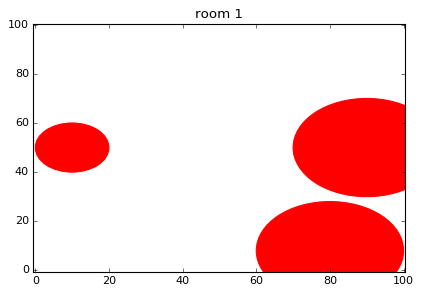

In [6]:

#_______________________________________ Plot the rooms


import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
LRRL()

def plot_world(World):
    
    len_world = len(World)
    
    ArrivalPoints = []
    for i in World:
        #ArrivalPoints
        for y in World[i]['Gate Openers']:
            ArrivalPoints.append([y[2], y[3]])  # the next room, where in the new room you appear,
    n_ArrivalPoints = len(ArrivalPoints)
    
    if len_world == 1:
        f, axarr = plt.subplots()        
    else:
        first_dimension = int((len_world+1-(len_world+1)%2)/2)
        f, axarr = plt.subplots(first_dimension, 2, sharex=True, sharey=True)
        
    plt.xlim(-.5, LRRL.room_size + .5)
    plt.ylim(-.5, LRRL.room_size + .5)
    f.subplots_adjust(wspace=.1, hspace=.2)
    
    for i in World:
        Rewards = []
        GateOpeners = []
        Doors = []

        # Rewards   
        for y in World[i]['Rewards']:
            circle = plt.Circle(y[0], y[1], color='r')
            Rewards.append(circle)

        #GateOpeners
        for y in World[i]['Gate Openers']:
            circle = plt.Circle(y[0], y[1], color='b')
            GateOpeners.append(circle)

        #Doors
        for y in World[i]['Gate Openers']:
            circle = plt.Circle(y[4], y[5], color='g')
            Doors.append(circle)  
        
        la_x = int((i-1-(i-1)%2)/2)
        if len_world == 1:
            ax = axarr
            ax.set_title('room 1')
        else:
            ax = axarr[la_x,1-i%2]
            ax.set_title('room %d'%i)
            
        for j in range(n_ArrivalPoints):
            if ArrivalPoints[j][0] == i:
                ax.plot(ArrivalPoints[j][1][0], ArrivalPoints[j][1][1], 'x')

        for i in Rewards+GateOpeners+Doors:
            ax.add_artist(i)

    if len_world%2 and len_world > 1:
        i = len(World)+1
        la_x = int((i-1-(i-1)%2)/2)
        f.delaxes(axarr[la_x,1])
        
    return f, axarr
        
    #f.savefig('easyworldplotcircles.pdf', format='pdf')
        
plot_world(easy_world)

# __Run the Agent in the World!__

this is the hardest part computationally, it takes relatively long.

In [ ]:
agents = ['creative', 'non-creative', 'random-walker', 'random-motionless']

for repeat in range(4):

    # run the code, this is the longes step
    # for T=100000 it took 20 minutes 
    # for T=10000 it took 2 minutes 
    # for T=1000 it took 1 minutes 
    total_time = 1000000
    MyAgent = LRRL(agent_type = agents[repeat])
    MyAgent.learner_life(T=total_time,world=easy_world)

    # save object in case I want to reuse it at some point
    import pickle
    file_pi = open('My_%s_AgentRepetition%d.obj'%(agents[repeat],repeat), 'w') 
    pickle.dump([MyAgent, easy_world], file_pi)





# __Once everything has been produced, make the plots!__

## __Plot 1: the actions taken by each agent__

In [ ]:
import pickle
 

MyCreativeAgent, easy_world = pickle.load( open( "MyFirstAgentRepetition0.obj", "rb" ) )
MyNonCreativeAgent, easy_world = pickle.load( open( "MyFirstAgentRepetition1.obj", "rb" ) )
MyRandomAgent, easy_world = pickle.load( open( "MyFirstAgentRepetition2.obj", "rb" ) )
MyMeditatingAgent, easy_world = pickle.load( open( "MyFirstAgentRepetition3.obj", "rb" ) )

In [ ]:
# plot which actions are selected by each agent

total_time = 1000000
agents = [MyRandomAgent, MyMeditatingAgent, MyNonCreativeAgent, MyCreativeAgent]   #
agents_names = ['random_agent', 'meditative', 'non-creative', 'creative']

actions_matrix_list = []

for i in range(len(agents)):
    actions_matrix = np.zeros((LRRL.n, total_time))

    for j in range(total_time):
        a = agents[i].list_of_actions[j]
        actions_matrix[a,j] = 1
    
    actions_matrix_list.append(actions_matrix)   


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

f, axarr = plt.subplots(len(agents),1, sharex=True, sharey=True,figsize=(10,10))

for i in range(len(agents)):
    ax = axarr[i]
    ax.set_title(agents_names[i])
    ax.imshow(actions_matrix_list[i], interpolation='nearest', cmap=plt.cm.ocean)   #aspect=5,
    
    
    ax.set_ylim([0,23])
    ax.relim()
    ax.set_xlim([0,total_time])
    

plt.show()

f.savefig('agents_and_actions.pdf', format='pdf')

## __Plot 2: paths, stacks evolutions and rewards evolutions__

In [32]:
import pickle

MyAgent, easy_world = pickle.load( open( "MyFirstAgentRepetition3.obj", "rb" ) )

if MyAgent.agent_type == 0:
    name = 'creative'        
elif MyAgent.agent_type == 1:
    name = 'non-creative'
elif MyAgent.agent_type == 2:
    name = 'random-walker' 
elif MyAgent.agent_type == 3:
    name = 'meditative'

1
meditative_agents_path_from0to1000.pdf
meditative_agents_path_from40000to41000.pdf


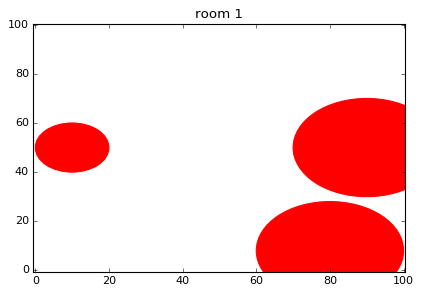

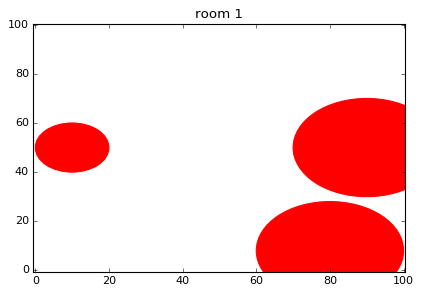

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

#f, axarr = plt.subplots(1,4, sharex=True, sharey=True,figsize=(15,5))

total_time = 1000000
# draw path and save it
path = np.ones((2,len(MyAgent.path)))

print len(MyAgent.path)

for i in range(len(MyAgent.path)):
    path[0,i] = MyAgent.path[i][2][0]
    path[1,i] = MyAgent.path[i][2][1]

for k in [0, 40000]:
    plt.figure()
    plot_world(easy_world)
    plt.plot(path[0,k:k+1000],path[1,k:k+1000],'-')

    plt.xlim(-.5, LRRL.room_size + .5)
    plt.ylim(-.5, LRRL.room_size + .5)
    
    plt.savefig(name+'_agents_path_from%dto%d.pdf'%(k,k+1000), format='pdf')
    print name+'_agents_path_from%dto%d.pdf'%(k,k+1000)

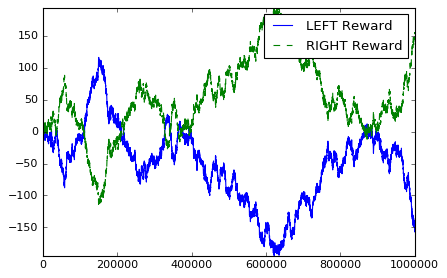

In [34]:
# plot reward evolution of each modulo
time_steps = np.asarray(MyAgent.LEFT_reward_track[0])
LEFT_reward_track = np.asarray(MyAgent.LEFT_reward_track[1])
RIGHT_reward_track = np.asarray(MyAgent.RIGHT_reward_track[1])

plt.xlim(-.2,total_time)
plt.ylim(min(min(LEFT_reward_track),min(RIGHT_reward_track)),max(max(LEFT_reward_track),max(RIGHT_reward_track)))

LEFT, = plt.plot(time_steps,LEFT_reward_track,'-')
RIGHT, = plt.plot(time_steps,RIGHT_reward_track,'--')
plt.legend([LEFT, RIGHT], ['LEFT Reward', 'RIGHT Reward'])

plt.savefig(name+'_agents_reward_evolution.pdf', format='pdf')

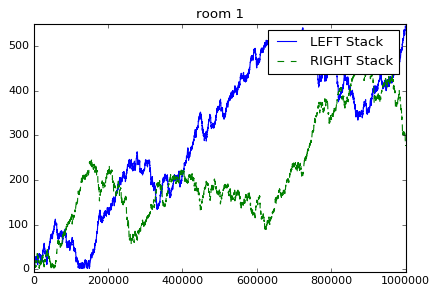

In [35]:
# plot stacks growing and dying

len_L = len(MyAgent.size_LEFT_Stack)
len_R = len(MyAgent.size_RIGHT_Stack)

xL = np.zeros(len_L)
yL = np.zeros(len_L)
xR = np.zeros(len_R)
yR = np.zeros(len_R)

for i in range(len_L):
    xL[i] = MyAgent.size_LEFT_Stack[i][0]
    yL[i] = MyAgent.size_LEFT_Stack[i][1]
    
for i in range(len_R):
    xR[i] = MyAgent.size_RIGHT_Stack[i][0]
    yR[i] = MyAgent.size_RIGHT_Stack[i][1]


max_Stack = max(max(yL), max(yR))
        
plot_world(easy_world)
plt.xlim(-.2,total_time)
plt.ylim(-max_Stack/100,max_Stack + max_Stack/100)

LEFT, = plt.plot(xL,yL,'-')
RIGHT, = plt.plot(xR,yR,'--')
plt.legend([LEFT, RIGHT], ['LEFT Stack', 'RIGHT Stack'])

plt.savefig(name+'_agents_stacks_evolution.pdf', format='pdf')

In [23]:
! pwd

/scratch/celottil/Dropbox/aaa recherche Jean IGLU/3. Verschlüsselung/Gödel Machine
